In [1]:
#analysis of a comprehensive dataset from Airbnb listings in New York City.
#Our objective is to develop a model that can predict the price of Airbnb listings, valuble insights for hosts 

import sqlite3
from sqlite3 import Error
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import numpy as np


path = 'C:\My_Workroom\Academics\EAS_503_Python_for_Data_Scientists\Final_Project\AIRBNB.csv'
expanded_path = os.path.expanduser(path)
data = pd.read_csv(expanded_path)

#dropping null values
data = data.dropna()

#Display first few rows of data 
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [2]:
#Converting the data to a normalized data model and parsing data into database 

db_path = r'C:\My_Workroom\Academics\EAS_503_Python_for_Data_Scientists\Final_Project\airbnb.db'
conn = sqlite3.connect(db_path)

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)
    return conn


def create_table(conn, create_table_sql, drop_table_name=None):    
    if drop_table_name: 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        


def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


def select_host(conn):
    sql = "select hosts_id, id from Host"
    data = execute_sql_statement(sql, conn)
    host_dict = {i: Hosts_id for i,Hosts_id in data}
    return host_dict


def select_location(conn):
    sql = "SELECT location_id, latitude, longitude FROM Location"
    data = execute_sql_statement(sql, conn)
    location_dict = {(latitude, longitude): location_id for location_id, latitude, longitude in data}
    return location_dict

        
def select_property(conn):
    sql = '''select  name, property_id  from Properties'''
    data = execute_sql_statement(sql, conn)
    property_dict = {property_id: name for property_id , name in data}
    return property_dict


conn = create_connection('airbnb.db', delete_db = True)
create_hosts = '''CREATE TABLE Host (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    hosts_id INTEGER not null,
    host_listings_count not null,
    host_name TEXT not null
);'''
create_table(conn, create_hosts, drop_table_name = 'Host')
host_data = set()
insert_host = '''insert into Host(hosts_id, host_listings_count, host_name) values (?,?,?)'''
with open(expanded_path, 'r', encoding='utf-8') as file:
    next(file)
    line = csv.reader(file)
    next(line)
    for i in line:
        host_id = i[2]
        listings = i[14]
        host_name = i[3]
        host_data.add((host_id,listings,host_name))
    cur = conn.cursor()
    cur.executemany(insert_host, host_data)
    conn.commit()

        
create_location = '''CREATE TABLE Location (
    location_id INTEGER PRIMARY KEY AUTOINCREMENT,
    neighbourhood_group TEXT,
    neighbourhood TEXT,
    latitude REAL,
    longitude REAL
);'''
create_table(conn, create_location, drop_table_name = 'Location')
insert_location = '''insert into Location( neighbourhood_group, neighbourhood, latitude, longitude) values(?,?,?,?)'''
location_data = []
with open (expanded_path, 'r', encoding='utf-8') as file:
    next(file)
    line = csv.reader(file)
    for i in line:
        neighbourhood_group = i[4]
        neighbourhood = i[5]
        latitude = i[6]
        longitude = i[7]
        location_data.append((neighbourhood_group, neighbourhood, latitude, longitude))
   
    cur = conn.cursor()
    cur.executemany(insert_location, (location_data))
    conn.commit()  
    

create_properties = '''CREATE TABLE Properties (
    property_id INTEGER PRIMARY KEY,
    name TEXT,
    host_id INTEGER,
    location_id INTEGER,
    room_type TEXT,
    FOREIGN KEY (host_id) REFERENCES Host (id),
    FOREIGN KEY (location_id) REFERENCES Location (location_id)
);'''

host_ids = select_host(conn)
location_ids = select_location(conn)



create_table(conn, create_properties, drop_table_name = 'Properties')
insert_property = '''insert into Properties(name, host_id, location_id, room_type) values(?,?,?,?)'''
property_data = []
with open(expanded_path, 'r', encoding='utf-8') as file:
    line = csv.reader(file)
    next(line)
    for i in line:
        name = i[1]
        host_id = int(i[2])
        latitude = float(i[6])
        longitude = float(i[7])
        room_type = i[8]
        hid = host_ids.get(host_id)
        location_id = location_ids.get((latitude, longitude)) 
        property_data.append((name, hid, location_id, room_type))   
    
    cur = conn.cursor()
    cur.executemany(insert_property, property_data)
    conn.commit()


        
create_bookings = '''CREATE TABLE Bookings (
    booking_id INTEGER PRIMARY KEY AUTOINCREMENT,
    property_id INTEGER,
    price INTEGER,
    minimum_nights INTEGER,
    availability_365 INTEGER,
    FOREIGN KEY (property_id) REFERENCES Properties (property_id)
);'''
property_ids = select_property(conn)

create_table(conn, create_bookings, drop_table_name = 'Booking')
insert_booking = '''INSERT INTO Bookings (property_id, price, minimum_nights, availability_365) VALUES (?, ?, ?, ?)'''
bookings_data = []
with open(expanded_path, 'r', encoding='utf-8') as file:
    line = csv.reader(file)
    next(line)
    for i in line:
        name = i[1]
        price = i[9]
        min_nights = i[10]
        availability = i[15]      
        pid = property_ids.get(name)
        bookings_data.append((pid, price, min_nights, availability))    

    cur = conn.cursor()
    cur.executemany(insert_booking, bookings_data)
    conn.commit()
    
 
        

create_Reviews = '''CREATE TABLE Reviews (
    review_id INTEGER PRIMARY KEY AUTOINCREMENT,
    property_id INTEGER,
    number_of_reviews INTEGER,
    last_review TEXT,
    reviews_per_month REAL,
    FOREIGN KEY (property_id) REFERENCES Properties (property_id)
);'''

create_table(conn, create_Reviews, drop_table_name = 'Reviews')
insert_review = '''INSERT INTO Reviews (property_id, number_of_reviews, last_review, reviews_per_month) VALUES (?, ?, ?, ?)'''
reviews_data = []
with open(expanded_path, 'r', encoding='utf-8') as file:
    line = csv.reader(file)
    next(line)
    for i in line:
        name = i[1]
        number_of_reviews = i[11]
        last_review = i[12]
        reviews_per_month = i[13]
        pid = property_ids.get(name)
        reviews_data.append((pid, number_of_reviews, last_review, reviews_per_month))

    cur = conn.cursor()
    cur.executemany(insert_review, reviews_data)
    conn.commit()
    conn.close()


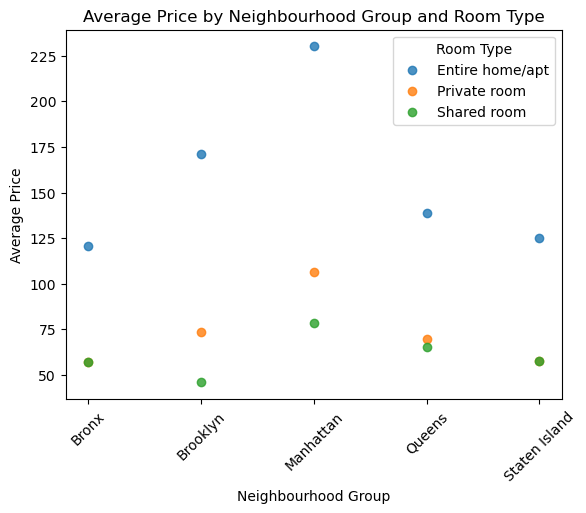

In [7]:
#Query to retreive the average price by neighbourhood group and room type

conn = create_connection('airbnb.db', delete_db = False)
query1 = """
SELECT L.neighbourhood_group, P.room_type, AVG(B.price) as average_price FROM Bookings B
JOIN Properties P ON B.property_id = P.property_id
JOIN Location L ON P.location_id = L.location_id
GROUP BY L.neighbourhood_group, P.room_type
"""
df = pd.read_sql_query(query1, conn)

for room_type in df['room_type'].unique():
    subset = df[df['room_type'] == room_type]
    plt.scatter(subset['neighbourhood_group'], subset['average_price'], label=room_type, alpha=0.8)
    
    
#plot 
plt.title('Average Price by Neighbourhood Group and Room Type')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price')
plt.legend(title='Room Type')
plt.xticks(rotation=45)
plt.show()

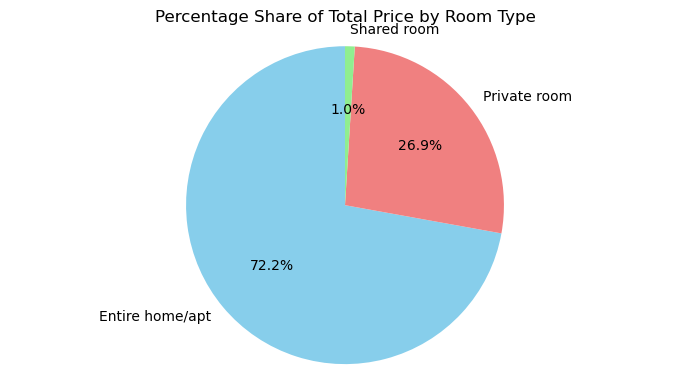

In [8]:
#Query to find Percentage share of Total price by room type

conn = create_connection('airbnb.db', delete_db = False)
query = """
SELECT room_type, SUM(price) as total_price
FROM Properties
JOIN Bookings ON Properties.property_id = Bookings.property_id
GROUP BY room_type;
"""
data = pd.read_sql_query(query, conn)
total_price = data['total_price'].sum()
data['percentage_share'] = (data['total_price'] / total_price) * 100

# Plotting
plt.figure(figsize=(7, 4))
custom_colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon']
plt.pie(data['percentage_share'], labels=data['room_type'], autopct='%1.1f%%', startangle=90,colors=custom_colors)
plt.title('Percentage Share of Total Price by Room Type')
plt.axis('equal')
plt.tight_layout()
plt.show()

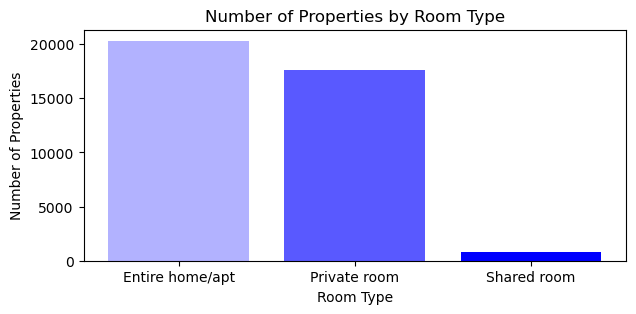

In [9]:
#Query to retrieve the number of properties by room type
query2 = """SELECT room_type, COUNT(*) as count FROM Properties GROUP BY room_type"""

cur = conn.cursor()
cur.execute(query2)
data = cur.fetchall()

room_types, counts = zip(*data)

base_color = 'blue'

alpha_values = np.linspace(0.3, 1, len(room_types))

plt.figure(figsize=(7, 3))
for i, (room_type, count) in enumerate(zip(room_types, counts)):
    plt.bar(room_type, count, color=base_color, alpha=alpha_values[i])

plt.title('Number of Properties by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Number of Properties')

plt.show()


In [10]:
#creating dataframe by joining all the tables for further analysis
conn = create_connection('airbnb.db', delete_db = False)
query = """
SELECT H.hosts_id, H.host_listings_count, H.host_name, L.neighbourhood_group, L.neighbourhood, L.latitude, L.longitude, P.name AS property_name, P.room_type,B.price, B.minimum_nights, B.availability_365,R.number_of_reviews, R.last_review, R.reviews_per_month
FROM Host H JOIN Properties P ON H.id = P.host_id JOIN Location L ON P.location_id = L.location_id
JOIN Bookings B ON P.property_id = B.property_id JOIN Reviews R ON P.property_id = R.property_id
"""

data = pd.read_sql_query(query, conn)
conn.close()
expanded_path = os.path.expanduser('C:\My_Workroom\Academics\EAS_503_Python_for_Data_Scientists\Final_Project\AIRBNB.csv')
data.to_csv(expanded_path, index=False)

data.head()


,hosts_id,host_listings_count,host_name,neighbourhood_group,neighbourhood,latitude,longitude,property_name,room_type,price,minimum_nights,availability_365,number_of_reviews,last_review,reviews_per_month
0,2787,6,John,Brooklyn,Kensington,40.64749,-73.97237,Clean & quiet apt home by the park,Private room,149,1,365,9,2018-10-19,0.21
1,2845,2,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Skylit Midtown Castle,Entire home/apt,225,1,355,45,2019-05-21,0.38
2,4869,1,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Cozy Entire Floor of Brownstone,Entire home/apt,89,1,194,270,2019-07-05,4.64
3,7192,1,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire Apt: Spacious Studio/Loft by central park,Entire home/apt,80,10,0,9,2018-11-19,0.10
4,7322,1,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Large Cozy 1 BR Apartment In Midtown East,Entire home/apt,200,3,129,74,2019-06-22,0.59


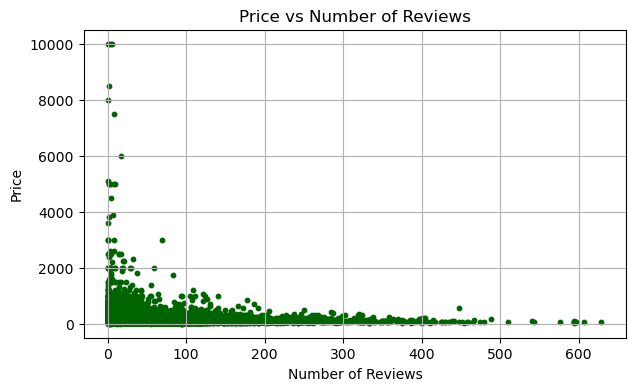

In [11]:
#plot price vs number of reviews
colors = ['darkgreen']
plt.figure(figsize=(7, 4))
plt.scatter(data['number_of_reviews'], data['price'], s=10,color=colors)
plt.title('Price vs Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.grid(True)
plt.show()


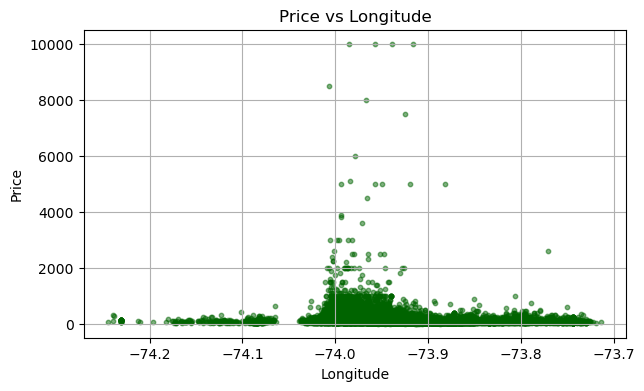

In [12]:
#plot price vs longitude
colors = ['darkgreen']
plt.figure(figsize=(7, 4))
plt.scatter(data['longitude'], data['price'], alpha=0.5, s=10,color=colors)  
plt.title('Price vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Price')
plt.grid(True)
plt.show()

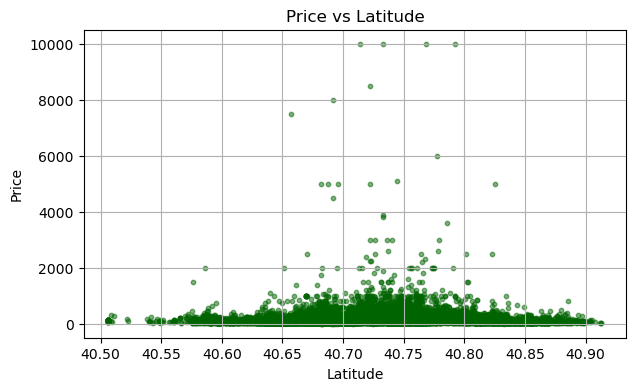

In [24]:
#plot price vs latitude
colors = ['darkgreen']
plt.figure(figsize=(7, 4))
plt.scatter(data['latitude'], data['price'], alpha=0.5, s=10,color=colors)  
plt.title('Price vs Latitude')
plt.xlabel('Latitude')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [21]:
#Custom bold print function
def custom_print(line):
    return (f"\033[1m{line}\033[0m") 

In [85]:
#Linear Regression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data['price'] = data['price'].replace(0, 1e-10)  
data['log_price'] = np.log(data['price'])
independent_variables = ['host_listings_count', 'minimum_nights', 'availability_365', 
                         'number_of_reviews', 'reviews_per_month', 'latitude', 'longitude']
response_variable = 'log_price'

X = data[independent_variables]
Y = data[response_variable]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred
threshold = 2 * np.std(residuals)

outlier = np.abs(residuals) < threshold

y_test_ = y_test[outlier]
y_pred_ = y_pred[outlier]

mse_ = mean_squared_error(y_test_, y_pred_)
r2_ = r2_score(y_test_, y_pred_)

print(custom_print("mse linear:"), mse_)
print(custom_print("r2_linear:"), r2_)

mse linear: 0.29188535369679486
r2_linear: 0.15768498130336883


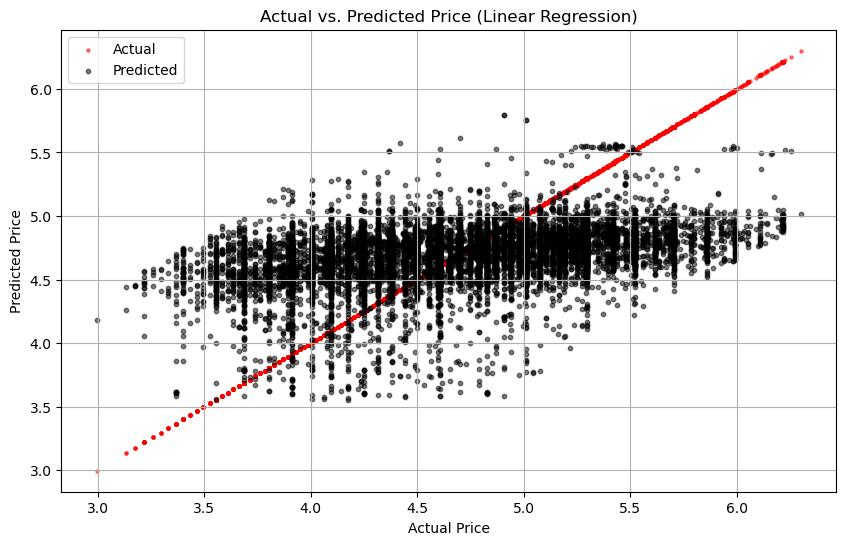

In [88]:
plt.figure(figsize=(10, 6))
plt.scatter((y_test_), (y_test_), color='red', alpha=0.5, s=5, label='Actual')
plt.scatter((y_test_), (y_pred_), color='black', alpha=0.5, s=10, label='Predicted')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price (Linear Regression)")
plt.legend()
plt.grid(True)

plt.show()


In [77]:
#Random Forest
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


X_rf = data[independent_variables]
Y_rf = data[response_variable]
X_train, X_test, y_train, y_test = train_test_split(X_rf, Y_rf, test_size=0.3, random_state=42)

random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)
y_pred_rf = np.maximum(y_pred_rf, 0)

non_negative = (y_test > 0) & (y_pred_rf >=0)
y_test = y_test[non_negative]
y_pred_rf = y_pred_rf[non_negative]


mse_random = mean_squared_error(y_test, y_pred_rf)
r2_random = r2_score(y_test, y_pred_rf)

print(custom_print("mse RF"), mse_random)
print(custom_print("R-squared RF"), r2_random)


mse RF 0.30394436647064144
R-squared RF 0.31278029012777053


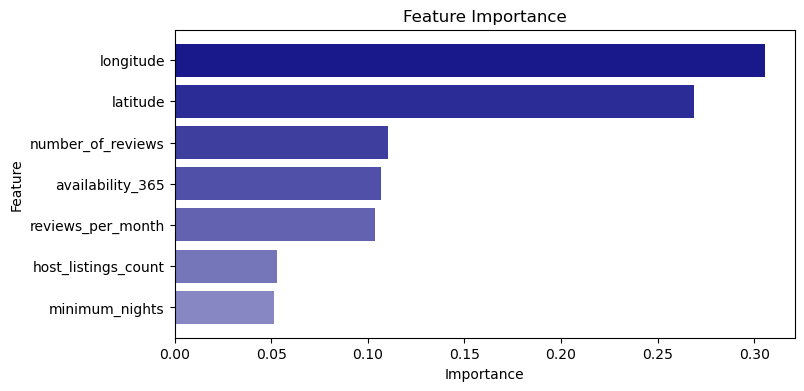

In [78]:
#Show Feature Importance plot
features = random_forest_model.feature_importances_
feature_df = pd.DataFrame({'Feature': independent_variables, 'Importance': features}).sort_values(by='Importance', ascending=False)

base_color = '#000080'

#Gradient color plotted feature bars
plt.figure(figsize=(8, 4))
for i, (feature, importance) in enumerate(zip(feature_df['Feature'], feature_df['Importance'])):
    alpha_value = 0.9 - 0.5 * (i / len(feature_df))
    plt.barh(feature, importance, color=base_color, alpha=alpha_value)

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()

plt.show()


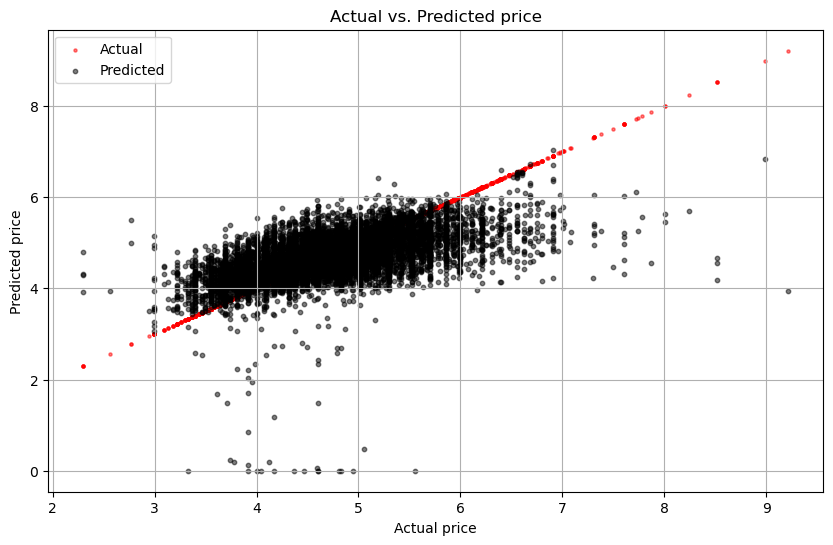

In [81]:
plt.figure(figsize=(10, 6))
plt.scatter((y_test), (y_test), color='red', alpha=0.5, s= 5 , label='Actual')
plt.scatter((y_test), (y_pred_rf), color='black', alpha=0.5,s=10, label='Predicted')

plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Actual vs. Predicted price")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
results_data = {
    'Model': ['Linear Regression', 'Random Forest'],
    'MSE': [mse_, mse_random],
    'R-squared': [r2_, r2_random]
}

results_df = pd.DataFrame(results_data)

styled_results_df = (
    results_df.style
    .set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('font-size', '16px')]},
        {'selector': 'td', 'props': [('font-size', '14px')]}
    ])
)
styled_results_df


,Model,MSE,R-squared
0,Linear Regression,0.291885,0.157685
1,Random Forest,0.303944,0.312780


In [1]:
from IPython.display import display, Markdown
conclusions_md = """
## Model Performance Comparison
### Interpretation:
- **Mean Squared Error (MSE):**
  - Lower MSE values are generally better. Linear Regression has a slightly lower MSE than Random Forest Model.
- **R-squared:**
  - Random Forest Model has a higher R-squared value, taking larger proportion of variance into consideration.
- **Conclusion:**
  - Random Forest Model is better suited for these types of datasets and performs slightly better than linear regression here.
"""
display(Markdown(conclusions_md))


## Model Performance Comparison
### Interpretation:
- **Mean Squared Error (MSE):**
  - Lower MSE values are generally better. Linear Regression has a slightly lower MSE than Random Forest Model.
- **R-squared:**
  - Random Forest Model has a higher R-squared value, taking larger proportion of variance into consideration.
- **Conclusion:**
  - Random Forest Model is better suited for these types of datasets and performs slightly better than linear regression here.
